In [29]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import numpy as np
from dolfin import *
#from dolfin_adjoint import *
#from src.Optimiser import objective_function#, #spacing_constraint

from solver2 import objective_function, solve_tidal_flow_velocities_fast, update_turbine_field, setup_tidal_solver
from Dolfin_optimisation.src.solver import (
    setup_swe_problem, setup_boundary_markers_and_bcs, solve_tidal_flow_velocities2
)
from Dolfin_optimisation.src.turbines import (
    place_turbines_random, compute_turbine_power, summarize_turbine_power, plot_turbine_layout
)
from Dolfin_optimisation.src.plots import plot_velocity_field, compute_power_field_plot, compare_layouts
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
#from dolfin_adjoint import *

# PETSc (quiet mode)
from petsc4py import PETSc
PETSc.Options()["ksp_monitor"] = None
PETSc.Options()["ksp_view"] = None


print("✅ Thesis SWE solver ready (v17-12)")

✅ Thesis SWE solver ready (v17-12)


In [92]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]

C_T = 0.7             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
D = 10               # Turbine diameter
sigma = D*0.5         # Wake Gaussian spread [m]

A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]
nu_eff = Constant(1.0)  # Effective viscosity [m²/s]
cb = 0.0025    # Bed friction coefficient [-]
viscosity = 3 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
nu = viscosity  # viscosity coefficient

# --- Initial conditions ---
initial_condition_u = Constant((0.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 400.0, 400.0
Nx, Ny = 100, 100

n_turbines = 10            # number of turbines
min_spacing = 5*D     # minimum spacing between turbines [m]
#random.seed(42)             # set a fixed seed for reproducibility

#----Showing plots or not----
mesh_plot = True
turbine_position_plot = True


print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


Success! Initialized u_init with U_inflow = 5.0 m/s on a 100x100 mesh.


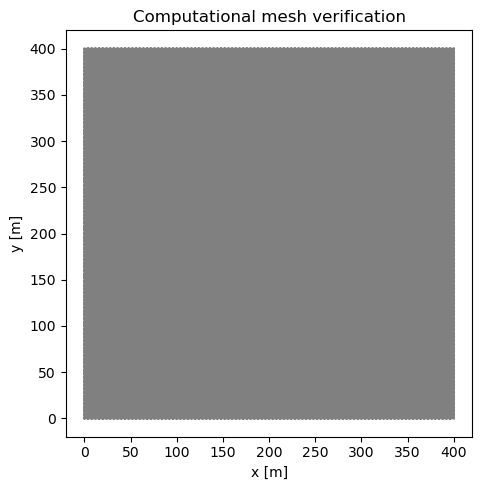

✅ Successfully placed 10 turbines after 18 attempts.
Initialized 10 turbines successfully.


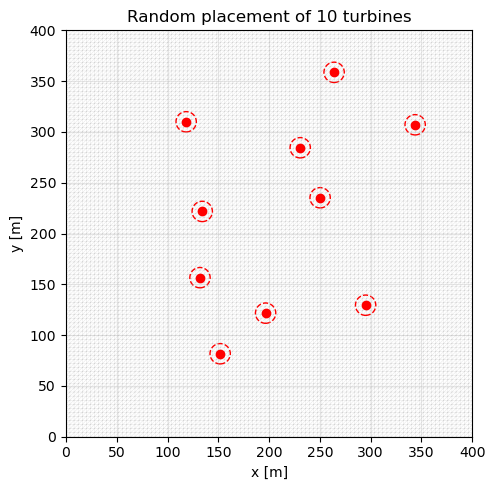

✅ Boundary markers created and BCs applied:
   - Inlet (ID=1): 5.0 m/s
   - Outflow (ID=2): marked for future use
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.247e+01 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 1.314e+00 (tol = 1.000e-08) r (rel) = 5.845e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 9.185e-03 (tol = 1.000e-08) r (rel) = 4.087e-04 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 8.315e-07 (tol = 1.000e-08) r (rel) = 3.700e-08 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 108157.5 kW


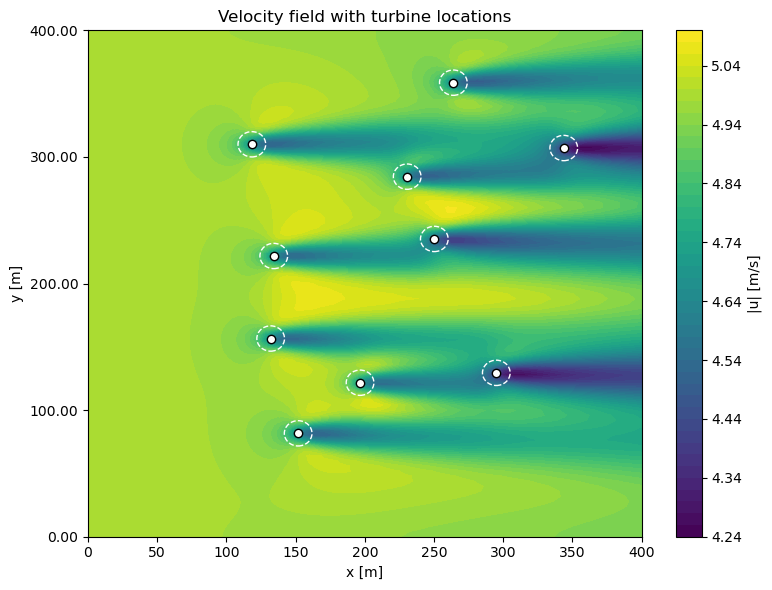

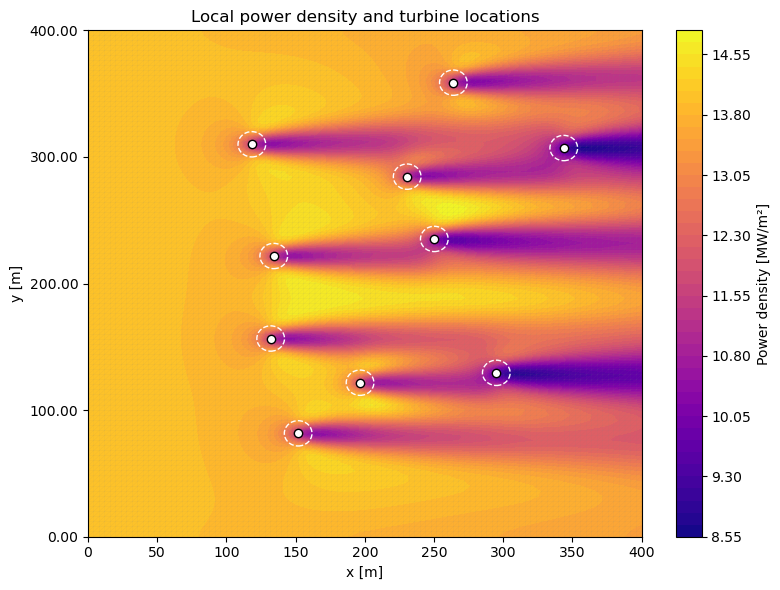

In [91]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q, inflow, outflow, walls = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, mesh_plot
)

turbine_positions = place_turbines_random(Lx, Ly, n_turbines, sigma, min_spacing)
x0 = np.array(turbine_positions).flatten() # Flatten initial turbine positions

plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, turbine_position_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, U_inflow)

init_total_power, init_velocity = solve_tidal_flow_velocities2(
    turbine_positions,
    w,
    W,
    mesh,
    bcs,
    rho,
    depth,
    nu,
    cb,
    g,
    C_T,
    A_T,
    sigma,
)

plot_velocity_field(w, turbine_positions, sigma, Lx, Ly)
compute_power_field_plot(C_T, rho, A_T, w, turbine_positions, sigma, Lx, Ly)

In [93]:
#  SETUP
solver_ctx = setup_tidal_solver(mesh, W, depth, nu, cb, g)
print("Solver context built, Zoë.")

bounds = [(0, Lx), (0, Ly)] * n_turbines

# Prepare unified objective wrapper
def objective_wrapper(x):
    return objective_function(x, solver_ctx, mesh, bcs, rho, C_T, A_T, sigma, D)

# Optional: small randomised initial population (diversify search)
init_population = np.vstack([
    x0,
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines)
])

# ------------------------------------------------------------
#  GLOBAL OPTIMISATION (Differential Evolution)
# ------------------------------------------------------------
print("\n Starting global differential evolution search.")

global_result = differential_evolution(
    func=objective_wrapper,     # call wrapper (no explicit args)
    bounds=bounds,
    init=init_population,       # start near current layout
    maxiter=2,                 # broad exploration
    popsize=5,
    mutation=(0.7, 1.2),
    recombination=0.8,
    updating='immediate',
    workers=1,                  # FEniCS and multiprocessing don't mix
    disp=False,
    polish=False                # we'll polish ourselves
)

print(f"\n Global search complete.")
print(f"   Best preliminary objective (negative power): {global_result.fun:.3e}")

# ------------------------------------------------------------
#  LOCAL OPTIMISATION (L‑BFGS‑B refinement)
# ------------------------------------------------------------
print("\n Refining solution locally with L‑BFGS‑B ...")

res_local = minimize(
    objective_wrapper,
    x0=global_result.x,         # start from DE best layout
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 2, 'disp': False}
)

# ------------------------------------------------------------
#  CHOOSE FINAL RESULT
# ------------------------------------------------------------
if res_local.fun < global_result.fun:
    best_result = res_local
    source = "Local (refined)"
else:
    best_result = global_result
    source = "Global (no improvement)"

opt_positions = best_result.x.reshape(-1, 2)
print(f"\n Hybrid optimisation complete — using {source} result.")
print(f" Final objective (negative power): {best_result.fun:.3e}")

best_power_global = -global_result.fun
best_power_local = -res_local.fun
print(f"Best power after global search: {best_power_global/1e3:.2f} kW")
print(f"Best power after local refinement: {best_power_local/1e3:.2f} kW")



Solver context built, Zoë.

 Starting global differential evolution search.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Initial guess reset to inflow velocity field.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.791e+03 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 2.041e+03 (tol = 1.000e-08) r (rel) = 3.006e-01 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 6.129e+02 (tol = 1.000e-08) r (rel) = 9.025e-02 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.839e+02 (tol = 1.000e-08) r (rel) = 2.708e-02 (tol = 1.000e-07)
  Newton iteration 4: r (abs) = 5.518e+01 (tol = 1.000e-08) r (rel) = 8.125e-03 (tol = 1.000e-07)
  Newton iteration 5: r (abs) = 1.655e+01 (tol = 1.000e-08) r (rel) = 2.438e-03 (tol = 1.000e-07)
  Newton iteration 6: r (abs) = 4.966e+00 (tol = 1.00

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.600e+01 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 1.215e+00 (tol = 1.000e-08) r (rel) = 4.673e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 2.662e-03 (tol = 1.000e-08) r (rel) = 1.024e-04 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.858e-08 (tol = 1.000e-08) r (rel) = 7.148e-10 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 108362.8 kW
Maximum theoretical power per turbine (Betz-adjusted): 586.06 kW
Momentum-sink (raw thrust) power per turbine:          901.

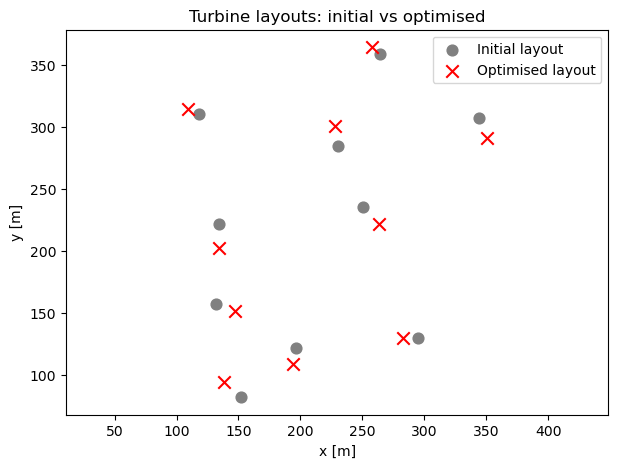

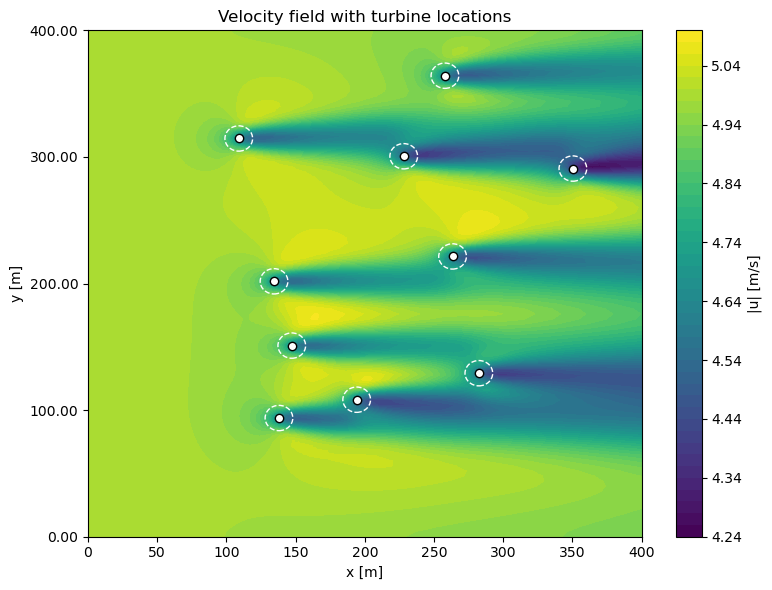

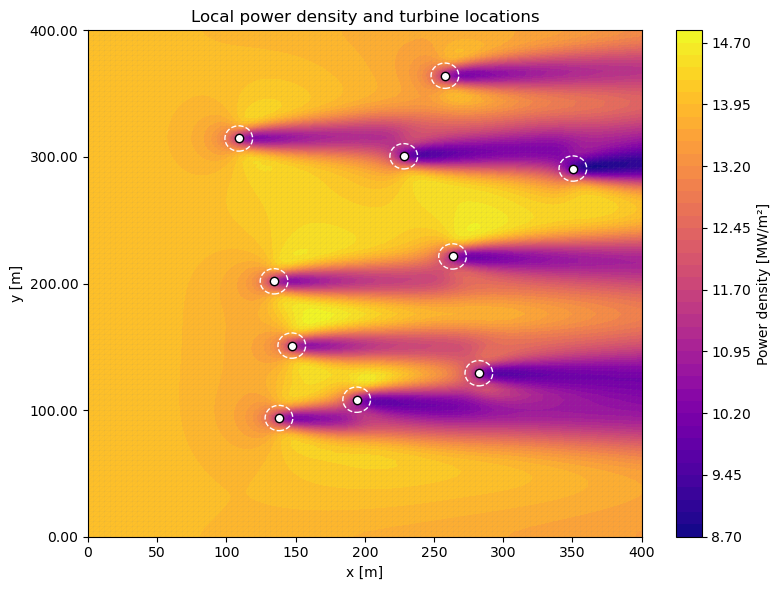

In [94]:
# --- Compute power and velocity for optimal layout ---

opt_total_power, opt_velocity = solve_tidal_flow_velocities(
    opt_positions,
    w, W, mesh, bcs,
    rho, depth, nu, cb, g,
    C_T, A_T, sigma,
)

# --- Compute per-turbine data for optimal layout ---
opt_turbine_powers, opt_turbine_velocities = compute_turbine_power(
    opt_velocity, opt_positions, rho, C_T, A_T
)

# --- Summarise results ---
opt_total_power_check, opt_max_park_power, _, _ = summarize_turbine_power(
    opt_turbine_powers, opt_turbine_velocities,
    rho, C_T, A_T, U_inflow, n_turbines
)

# --- Compute relative improvement and efficiency ---
improvement_pct = (opt_total_power_check - init_total_power) / init_total_power * 100
efficiency_pct = opt_total_power_check / opt_max_park_power * 100

# --- Print clean summary ---
print("\n========  LAYOUT OPTIMISATION SUMMARY  ========")
print(f"{'Initial total power:':35s} {init_total_power/1e3:10.2f} kW")
print(f"{'Optimised total power:':35s} {opt_total_power_check/1e3:10.2f} kW")
print(f"{'Maximum theoretical power (no wake):':35s} {opt_max_park_power/1e6:10.2f} MW")
print(f"{'Relative improvement:':35s} {improvement_pct:10.2f} %")
print(f"{'Farm efficiency:':35s} {efficiency_pct:10.2f} %")
print("===============================================\n")

# --- Combined layout comparison ---
compare_layouts(mesh, Lx, Ly, turbine_positions, opt_positions, sigma)

# --- Velocity and power field plots for optimal layout ---
plot_velocity_field(w, opt_positions, sigma, Lx, Ly)
compute_power_field_plot(C_T, rho, A_T, w, opt_positions, sigma, Lx, Ly)


In [1]:
try:
    import dolfin_adjoint
    print("✅ dolfin_adjoint is installed.")
except ImportError:
    print("❌ dolfin_adjoint not found.")

try:
    import pyadjoint
    print("✅ pyadjoint is installed.")
except ImportError:
    print("❌ pyadjoint not found.")

import dolfin, dolfin_adjoint
print(dolfin.__file__)
print(dolfin_adjoint.__file__)


/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ dolfin_adjoint is installed.
✅ pyadjoint is installed.
/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/__init__.py
/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin_adjoint/__init__.py
